In [15]:
import os
import gzip
import pickle
from collections import defaultdict

%load_ext sql
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'

figdir = '/home/glandrum/Papers/MolecularTimeSeries/images/'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
import intake
import numpy as np
import ga_lib_3 as ga_lib
from rdkit import DataStructs

def score_pareto_solutions(Fs,weights,q=0.9):
    weights = np.array(weights)
    Fs = np.copy(Fs)
    qs = np.quantile(Fs,q,axis=0)
    for i in range(len(qs)):
        if qs[i]==0.0:
            qs[i] = 1.0
    Fs /= qs
    Fs = np.exp(Fs*-1)
    weights = np.array(weights,float)
    # normalize:
    weights /= np.sum(weights)
    
    Fs *= weights
    return np.sum(Fs,axis=1)


from sklearn.model_selection import StratifiedShuffleSplit
def alt_compliance_analysis(target,strategy='CLUSTERS_SPLIT',popSize=500,nGens=300,
                           isBalanced=True, noGap=True):

    sel_strategy = getattr(ga_lib.SelectionStrategy,strategy)

    bioactivities = intake.open_catalog('./datasets/targets.yaml')

    if noGap:
        dirname = "nogap_"
        window = 0.0
    else:
        dirname = ""
        window = 0.3
    if not isBalanced:
        dirname += 'alt_results_imbalanced'
    else:
        dirname += 'alt_results_balanced'
    
    
    for scen in range(2):
        fname = f'./{dirname}/{target}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            # short-circuit if we can't find results for one scenario
            return {}

    
    ds = bioactivities[target]
    print('------------\nLoading data')
    df = ds.read()
    # randomize the order:
    df = df.sample(frac=1,random_state=0xf00d)
    
    
    # Use the binning scheme
    # generate the binned activity values
    pActs = df.pchembl_value
    if not isBalanced:
        upper, lower = ga_lib.get_imbalanced_bins(pActs)
    else:
        upper, lower = ga_lib.get_imbalanced_bins(pActs,tgt_frac=0.4,active_inactive_offset=window)
    print(f'  bins are: {lower:.2f} {upper:.2f}')
    df = df[(pActs >= upper) | (pActs <= lower)]
    binned = [1 if x >= upper else 0 for x in df.pchembl_value]
    df['active'] = ['active' if x == 1 else 'inactive' for x in binned]
    print(f'  post-binning data size {len(df)}')
    
    dvals = np.array([ga_lib.calc_descrs(m) for m in df.mol])
    dtgts = ga_lib.get_descr_targets()
    fps = ga_lib.get_fps(df.mol)
    dmat = np.zeros((len(fps),len(fps)),float)
    for i,fp in enumerate(fps):
        if i==len(fps)-1:
            break
        ds = np.array(DataStructs.BulkTanimotoSimilarity(fp,fps[i+1:],returnDistance=1))
        dmat[i,i+1:] = ds
        dmat[i+1:,i] = ds
    print(len(df))
       
    max_pts = len(binned)
    keep = max_pts
    n_max = int(0.2*keep)
    print(f'working with {keep} points and picking {n_max}')

    
    binned = np.array(binned)

    res = {}

    for scen in range(2):
        fname = f'./{dirname}/{target}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            break
        with gzip.open(fname,'rb') as inf:
            train_inds,test_inds = pickle.load(inf)
            Fs,Gs,Xs = pickle.load(inf)

        tgts = [x.target_value for x in ga_lib.descrs]
        descr_names = [x.descriptor for x in ga_lib.descrs]
        nDescrs = len(descr_names)
        descr_names.append('delta_frac_active')
        tgts.append(ga_lib.delta_test_active_frac_vals[scen])

        vals = []
        for x in Xs:
            train = np.median(dvals[~x], axis=0)
            test = np.median(dvals[x], axis=0)
            descr_deltas = test - train
            lres = list(descr_deltas)
            
            train_acts = binned[~x]
            train_frac = np.sum(train_acts, axis=0) / len(train_acts)
            test_acts = binned[x]
            test_frac = np.sum(test_acts, axis=0) / len(test_acts)
            dTestFracActive = test_frac - np.sum(binned, axis=0)/len(binned)
            lres.append(dTestFracActive)
            
            allIdx = np.arange(0, len(x), dtype=int)
            testIdx = allIdx[x]
            trainIdx = allIdx[~x]
            _, g_vals, f_vals, _ = ga_lib.modified_spatial_stats_dmat(
                dmat, testIdx, trainIdx, includeTestInBootstrap=False)
            sum_F = np.sum(f_vals)
            sum_G = np.sum(g_vals)
            lres.append(sum_F)
            lres.append(sum_G)           
            vals.append(lres)
        res[scen] = (tgts,np.array(vals))
    # short circuit if we couldn't read in all the results
    if len(res)<2:
        return res
    
    # random split results
    sss = StratifiedShuffleSplit(n_splits = 10, test_size=0.2, random_state=0xf00d)
    fvs = []
    gvs = []
    for train,test in sss.split(fps,binned):
        _, g_vals, f_vals, _ = ga_lib.modified_spatial_stats_dmat(
            dmat, test, train, includeTestInBootstrap=False)
        sum_F = np.sum(f_vals)
        sum_G = np.sum(g_vals)
        fvs.append(sum_F)
        gvs.append(sum_G)
    res[-1] = (fvs,gvs)

    
    return res


In [3]:
bioactivities = intake.open_catalog('./datasets/targets.yaml')

alt_alltgts = defaultdict(list)
alt_alldesc = defaultdict(list)
random_fgvals = defaultdict(list)
for target in bioactivities:
    ares = alt_compliance_analysis(target)
    if 0 not in ares or 1 not in ares:
        print(f'skipping {target}')
        continue
    random_fgvals[-1].append(ares[-1])
    
    for scen in (0,1):
        alt_alltgts[scen].append(ares[scen][0])
        alt_alldesc[scen].append(ares[scen][1])

------------
Loading data
  bins are: 7.10 7.10
  post-binning data size 996
996
working with 996 points and picking 199
------------
Loading data
  bins are: 7.50 7.50
  post-binning data size 969
969
working with 969 points and picking 193
------------
Loading data
  bins are: 7.30 7.30
  post-binning data size 925
925
working with 925 points and picking 185
------------
Loading data
  bins are: 7.20 7.20
  post-binning data size 907
907
working with 907 points and picking 181
------------
Loading data
  bins are: 7.80 7.80
  post-binning data size 881
881
working with 881 points and picking 176
------------
Loading data
  bins are: 7.50 7.50
  post-binning data size 861
861
working with 861 points and picking 172
------------
Loading data
  bins are: 7.60 7.60
  post-binning data size 858
858
working with 858 points and picking 171
------------
Loading data
  bins are: 7.60 7.60
  post-binning data size 837
837
working with 837 points and picking 167
------------
Loading data
  bins

------------
Loading data
  bins are: 7.50 7.50
  post-binning data size 364
364
working with 364 points and picking 72
------------
Loading data
  bins are: 7.70 7.70
  post-binning data size 360
360
working with 360 points and picking 72
------------
Loading data
  bins are: 6.60 6.60
  post-binning data size 360
360
working with 360 points and picking 72
------------
Loading data
  bins are: 8.10 8.10
  post-binning data size 358
358
working with 358 points and picking 71
------------
Loading data
  bins are: 6.30 6.30
  post-binning data size 358
358
working with 358 points and picking 71
------------
Loading data
  bins are: 7.00 7.00
  post-binning data size 357
357
working with 357 points and picking 71
------------
Loading data
  bins are: 7.50 7.50
  post-binning data size 355
355
working with 355 points and picking 71
------------
Loading data
  bins are: 6.60 6.60
  post-binning data size 354
354
working with 354 points and picking 70
------------
Loading data
  bins are: 7.

In [4]:
import pickle
with open('./chembl_alt_moo_objectives.pkl','wb+') as outf:
    pickle.dump((alt_alltgts,alt_alldesc,random_fgvals),outf)
!chmod gou-w ./chembl_alt_moo_objectives.pkl

In [ ]:
import pickle
with open('./chembl_alt_moo_objectives.pkl','rb') as inf:
    (alt_alltgts,alt_alldesc,random_fgvals) = pickle.load(inf)

In [5]:
targets = intake.open_catalog('./datasets/targets.yaml')

strategy='CLUSTERS_SPLIT'
popSize=500
nGens=300
ares0 = defaultdict(list)
best_F0 = defaultdict(list)
ares1 = defaultdict(list)
best_F1 = defaultdict(list)
ares2 = defaultdict(list)
best_F2 = defaultdict(list)
idx = [0]
for target in targets:
    for scen in range(len(idx)):
        fname = f'./nogap_alt_results_balanced/{target}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            continue
        with gzip.open(fname,'rb') as inf:
            train_inds,test_inds = pickle.load(inf)
            Fs,Gs,Xs = pickle.load(inf)
        scores1 = score_pareto_solutions(Fs,weights=[1.]*7)
        scores2 = score_pareto_solutions(Fs,weights=[1.]*5+[10.,5.])
        best1 = np.argmax(scores1)
        best2 = np.argmax(scores2)
        
        best_F0[scen].append(Fs[0])
        best_F1[scen].append(Fs[best1])
        best_F2[scen].append(Fs[best2])
        
        ares0[scen].append(alt_alldesc[scen][idx[scen]][0])
        ares1[scen].append(alt_alldesc[scen][idx[scen]][best1])
        ares2[scen].append(alt_alldesc[scen][idx[scen]][best2])
        idx[scen] += 1

for k in ares1:
    for d in (ares0,ares1,ares2,best_F0,best_F1,best_F2):
        d[k] = np.array(d[k])
        

        

In [6]:
randomsplit_fvals = [np.median(x) for x,y in random_fgvals[-1]]
randomsplit_gvals = [np.median(y) for x,y in random_fgvals[-1]]

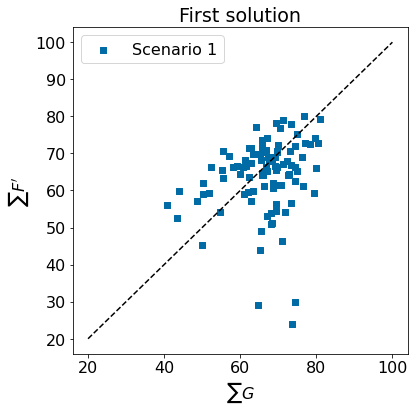

In [7]:
       
plt.figure(figsize=(6,6))
plt.scatter(ares0[0][:,6],ares0[0][:,5],marker='s',color='C0',label='Scenario 1');

plt.plot((20,100),(20,100),'k--')

    
    
plt.xlabel('$\sum G$');
plt.ylabel('$\sum F\'$');
plt.title('First solution');
plt.legend();

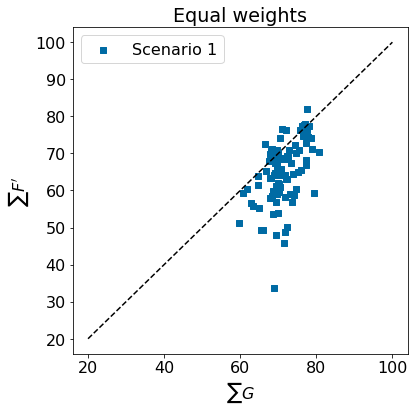

In [8]:
       
plt.figure(figsize=(6,6))
plt.scatter(ares1[0][:,6],ares1[0][:,5],marker='s',color='C0',label='Scenario 1');

plt.plot((20,100),(20,100),'k--')

    
    
plt.xlabel('$\sum G$');
plt.ylabel('$\sum F\'$');
plt.title('Equal weights');
plt.legend();

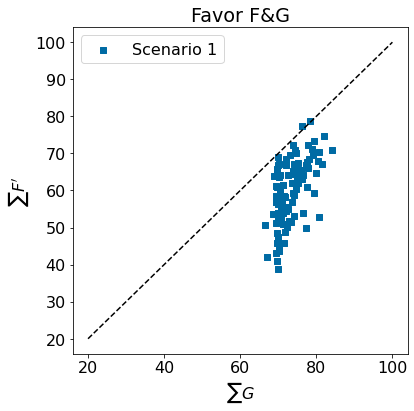

In [9]:
       
plt.figure(figsize=(6,6))
plt.scatter(ares2[0][:,6],ares2[0][:,5],marker='s',color='C0',label='Scenario 1');

plt.plot((20,100),(20,100),'k--')

    
    
plt.xlabel('$\sum G$');
plt.ylabel('$\sum F\'$');
plt.title('Favor F&G');
plt.legend();

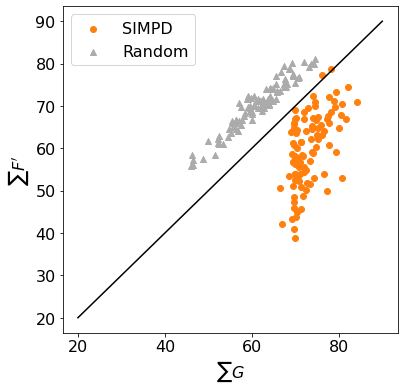

In [16]:
randomsplit_fvals = [np.median(x) for x,y in random_fgvals[-1]]
randomsplit_gvals = [np.median(y) for x,y in random_fgvals[-1]]

plt.figure(figsize=(6,6))
plt.scatter(ares2[0][:,6],ares2[0][:,5],marker='o',color='C1',label='SIMPD');
plt.scatter(randomsplit_gvals,randomsplit_fvals,marker='^',color='C2',label='Random');

plt.plot((20,90),(20,90),'k-')

    
    
plt.xlabel('$\sum G$');
plt.ylabel('$\sum F\'$');
plt.legend();
plt.savefig(f'{figdir}/chembl_assays_spatial_stats.pdf',bbox_inches='tight')


## Descriptors

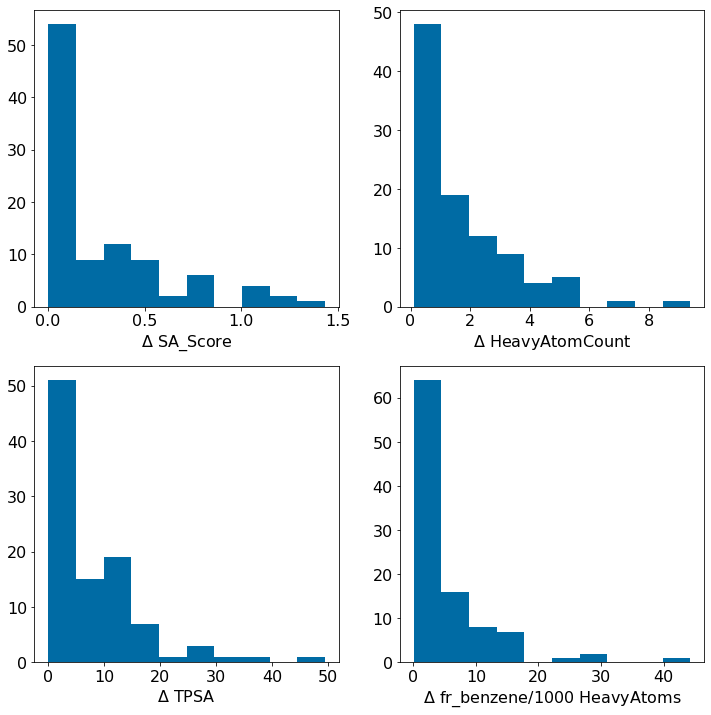

In [17]:
descrs = [x.descriptor for x in ga_lib.descrs]
plt.figure(figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.hist([best_F2[0][:,i]],label=('F&G',))
    plt.xlabel(f'$\Delta$ {descrs[i]}');
plt.savefig(f'{figdir}/chembl_assays_descriptor_match.pdf',bbox_inches='tight')


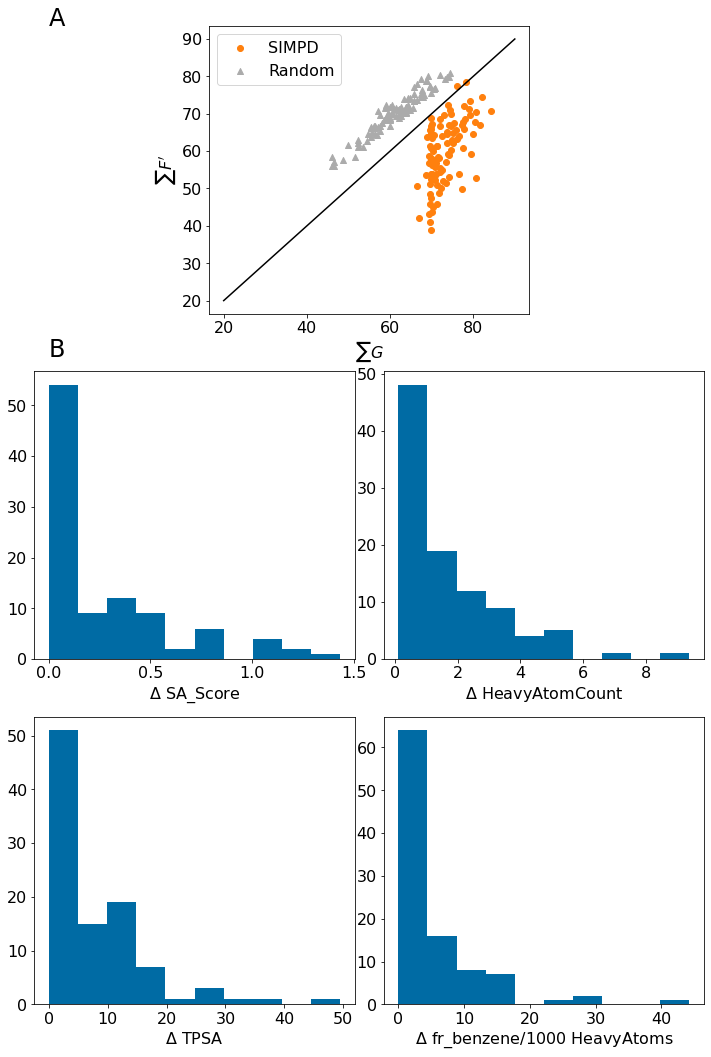

In [44]:
randomsplit_fvals = [np.median(x) for x,y in random_fgvals[-1]]
randomsplit_gvals = [np.median(y) for x,y in random_fgvals[-1]]
descrs = [x.descriptor for x in ga_lib.descrs]


from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12,18))


gs = GridSpec(3,4,figure=fig)




ax1 = fig.add_subplot(gs[0,1:3])

ax1.text(-.5,1,'A',transform=ax1.transAxes,fontsize=24)

ax1.scatter(ares2[0][:,6],ares2[0][:,5],marker='o',color='C1',label='SIMPD');
ax1.scatter(randomsplit_gvals,randomsplit_fvals,marker='^',color='C2',label='Random');

ax1.plot((20,90),(20,90),'k-')

    
    
ax1.set_xlabel('$\sum G$');
ax1.set_ylabel('$\sum F\'$');
ax1.legend();
# plt.savefig(f'{figdir}/chembl_assays_spatial_stats.pdf',bbox_inches='tight')


ax1.text(-.5,-.15,'B',transform=ax1.transAxes,fontsize=24)

ax2 = fig.add_subplot(gs[1,0:2])
ax2.hist([best_F2[0][:,0]],label=('F&G',))
ax2.set_xlabel(f'$\Delta$ {descrs[0]}');
ax2 = fig.add_subplot(gs[1,2:4])
ax2.hist([best_F2[0][:,1]],label=('F&G',))
ax2.set_xlabel(f'$\Delta$ {descrs[1]}');

ax2 = fig.add_subplot(gs[2,0:2])
ax2.hist([best_F2[0][:,2]],label=('F&G',))
ax2.set_xlabel(f'$\Delta$ {descrs[2]}');
ax2 = fig.add_subplot(gs[2,2:4])
ax2.hist([best_F2[0][:,3]],label=('F&G',))
ax2.set_xlabel(f'$\Delta$ {descrs[3]}');

plt.savefig(f'{figdir}/chembl_simpd_results_summary.pdf',bbox_inches='tight')


# ML Performance

In [12]:
from collections import namedtuple
restuple = namedtuple('restuple',['rocs','scores','kappas','BAs'])

import pickle
import glob
import os
import gzip
tmp_assays = glob.glob('./mfp0_nogap_ml_results_balanced/*.pkl.gz')
mfp0_nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    mfp0_nogap_random_results_bal[assay] = tpl

tmp_assays = glob.glob('./nogap_ml_results_balanced/*.pkl.gz')
nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    nogap_random_results_bal[assay] = tpl
    
   
fns = glob.glob('./nogap_alt_moo_ml_results_balanced/CHEMBL*.altscenario_0.favorfg_rf.pkl.gz')
results_moo_fg_bal = {}
for fn in fns:
    assay = os.path.basename(fn).split('_')[0]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    results_moo_fg_bal[assay] = tpl

fns = glob.glob('./nogap_alt_moo_ml_results_balanced/mfp0_CHEMBL*.altscenario_0.favorfg_rf.pkl.gz')
mfp0_results_moo_fg_bal = {}
for fn in fns:
    assay = os.path.basename(fn).split('_')[1]
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    mfp0_results_moo_fg_bal[assay] = tpl
        

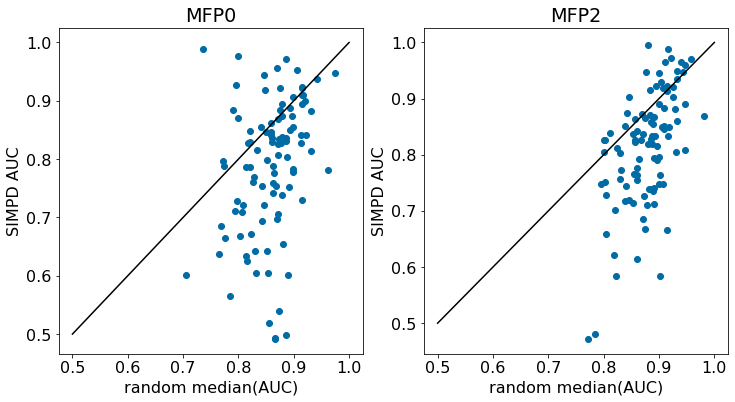

In [13]:
random_meds = [np.median(mfp0_nogap_random_results_bal[x].rocs) for x in nogap_random_results_bal]
#moo_meds = [np.median(results_moo_bal[x].rocs) for x in moo_assays]
moo_fg_first = [mfp0_results_moo_fg_bal[x].rocs[0] for x in nogap_random_results_bal]

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.scatter(random_meds,moo_fg_first,label='favor F&G');
plt.plot((.5,1),(.5,1),'k');
plt.xlabel('random median(AUC)')
plt.ylabel('SIMPD AUC');
plt.title('MFP0')

random_meds = [np.median(nogap_random_results_bal[x].rocs) for x in nogap_random_results_bal]
#moo_meds = [np.median(results_moo_bal[x].rocs) for x in moo_assays]
moo_fg_first = [results_moo_fg_bal[x].rocs[0] for x in nogap_random_results_bal]

plt.subplot(1,2,2)
plt.scatter(random_meds,moo_fg_first,label='favor F&G');
plt.plot((.5,1),(.5,1),'k');
plt.xlabel('random median(AUC)')
plt.ylabel('SIMPD AUC');
plt.title('MFP2');



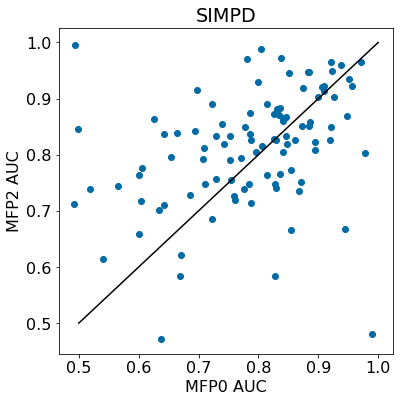

In [14]:
mfp0_moo_fg_first = [mfp0_results_moo_fg_bal[x].rocs[0] for x in nogap_random_results_bal]
moo_fg_first = [results_moo_fg_bal[x].rocs[0] for x in nogap_random_results_bal]

plt.figure(figsize=(6,6))

plt.scatter(mfp0_moo_fg_first,moo_fg_first,label='favor F&G');
plt.plot((.5,1),(.5,1),'k');
plt.xlabel('MFP0 AUC')
plt.ylabel('MFP2 AUC');
plt.title('SIMPD');




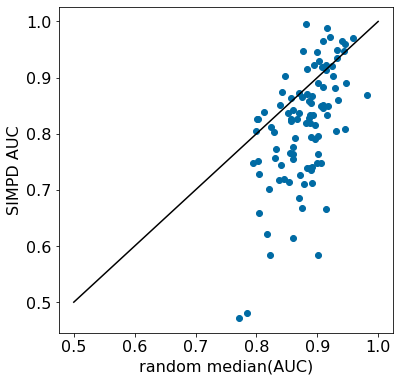

In [20]:

random_meds = [np.median(nogap_random_results_bal[x].rocs) for x in nogap_random_results_bal]
#moo_meds = [np.median(results_moo_bal[x].rocs) for x in moo_assays]
moo_fg_first = [results_moo_fg_bal[x].rocs[0] for x in nogap_random_results_bal]

plt.figure(figsize=(6,6))

plt.scatter(random_meds,moo_fg_first,label='favor F&G');
plt.plot((.5,1),(.5,1),'k');
plt.xlabel('random median(AUC)')
plt.ylabel('SIMPD AUC');




plt.savefig(f'{figdir}/chembl_assays_ga_impact_on_model_performance.pdf',bbox_inches='tight')
